In [8]:
import random
import matplotlib.pyplot as plt

In [9]:
class Node:
    def __init__(self,nactions):
        self.regretSum = [0.0] * nactions
        self.strategy = [0.0] * nactions
        self.strategySum  = [0.0] * nactions
        self.nactions = nactions
        self.pPlayer = 0.0
        self.pOpponent = 0.0
        self.utility = 0.0
    
    #get liar die node current mixed strategy with regret-matching
    def Strategy(self):
        normalizingSum = 0.0
        for a in range(self.nactions):
            self.strategy[a] = max(self.regretSum[a],0)
            normalizingSum += self.strategy[a]
            
        for a in range(self.nactions):
            if normalizingSum > 0:
                self.strategy[a] /= normalizingSum
            else:
                self.strategy[a] = 1.0 / self.nactions
                
        for a in range(self.nactions):
                self.strategySum[a] += self.pPlayer * self.strategy[a]
            
        return self.strategy
    
    #get liar die node average mixed strategy
    def AverageStrategy(self):
        average_strategy = [0.0] * self.nactions
        normalizingSum = sum(self.strategySum)
        for a in range(self.nactions):
            if normalizingSum > 0:
                average_strategy[a] = self.strategySum[a] / normalizingSum
            else:
                average_strategy[a] = 1.0 / self.nactions
        return average_strategy

In [10]:
def Initialisation(sides):
    responseNodes = [[Node(2) for _ in range(sides + 1)] for _ in range(sides)]
    for myClaim in range(sides + 1):
        for oppClaim in range(myClaim + 1,sides + 1):
            responseNodes[myClaim][oppClaim] = Node(
                1 if ((oppClaim == 0) or (oppClaim == sides))  
                else 2)
        claimNodes = [[Node(2) for _ in range(sides + 1)] for _ in range(sides)]
        for oppClaim in range(sides):
            for roll in range(1,sides + 1):
                claimNodes[oppClaim][roll] = Node(sides - oppClaim)
    return responseNodes, claimNodes

In [12]:
def train(iterations, record_interval=100, sides=6, DOUBT = 0, ACCEPT = 1, Actions = 2):
    responseNodes, claimNodes = Initialisation(sides)
    strategy_history = []
    
    for iter in range(iterations):
        #Initialize rolls with starting probabilities
        rollAfterAcceptingClaim = [random.randint(1, sides) for _ in range(sides)]
        
        claimNodes[0][rollAfterAcceptingClaim[0]].pPlayer = 1
        claimNodes[0][rollAfterAcceptingClaim[0]].pOpponent = 1
        
        #accumulate realization weights forward
        for oppClaim in range(sides + 1):
            #Visit response nodes forward
            if oppClaim > 0:
                for myClaim in range(oppClaim):
                    node = responseNodes[myClaim][oppClaim]
                    actionProb = node.Strategy()
                    if oppClaim < sides:
                        nextNode = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                        nextNode.pPlayer += actionProb[ACCEPT] * node.pPlayer
                        nextNode.pOpponent += node.pOpponent
                        
            #Visit claim node forward
            if oppClaim < sides:
                node = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                actionProb = node.Strategy()
                for myClaim in range(oppClaim+1,sides + 1):
                    nextClaimProb = actionProb[myClaim - oppClaim - 1]
                    if nextClaimProb > 0:
                        nextNode = responseNodes[oppClaim][myClaim]
                        nextNode.pPlayer += node.pOpponent
                        nextNode.pOpponent += nextClaimProb * node.pPlayer
                        
        #Backpropagate utilities, adjust regrets and strategies
        for oppClaim in range(sides, -1, -1):
            regret = [0.0] * sides
            #visit claim nodes backward
            if oppClaim < sides:
                node = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                actionProb = node.strategy.copy() # copy?
                node.u = 0.0
                for myClaim in range(oppClaim+1,sides + 1):
                    actionIndex = myClaim - oppClaim - 1
                    nextNode = responseNodes[oppClaim][myClaim]
                    childUtil = -nextNode.u
                    regret[actionIndex] = childUtil
                    node.u += actionProb[actionIndex] * childUtil
                for a in range(len(actionProb)):
                    node.regretSum[a] += node.pOpponent * regret[a]
                node.pPlayer = node.pOpponent = 0
                
            #visit response nodes backward 
            if oppClaim > 0:
                for myClaim in range(oppClaim):
                    node = responseNodes[myClaim][oppClaim]
                    actionProb = node.strategy # copy?
                    node.u = 0.0
                    doubtUtil = 1 if oppClaim > rollAfterAcceptingClaim[myClaim] else -1
                    regret[DOUBT] = doubtUtil 
                    node.u += actionProb[DOUBT] * doubtUtil
                    if oppClaim < sides:
                        nextNode = claimNodes[oppClaim][rollAfterAcceptingClaim[oppClaim]]
                        accept_util = nextNode.u
                        regret[ACCEPT] = accept_util
                        node.u += actionProb[ACCEPT] * accept_util
                    for a in range(len(actionProb)):
                        regret[a] -= node.u
                        node.regretSum[a] += node.pOpponent * regret[a]
                    node.pPlayer = node.pOpponent = 0
        #reset strategy sums after half of training
        if iter == iterations //2:
            for nodes in responseNodes:
                for node in nodes:
                        for a in range(len(node.strategySum)):
                            node.strategySum[a] = 0
            for nodes in claimNodes:
                for node in nodes:
                        for a in range(len(node.strategySum)):
                            node.strategySum[a] = 0
                            
        # Record strategies at specified intervals
        if iter % record_interval == 0 or iter == iterations - 1:
            snapshot = {}
            for my_claim in range(sides + 1):
                for opp_claim in range(my_claim + 1, sides + 1):
                    snapshot[(my_claim, opp_claim)] = responseNodes[my_claim][opp_claim].AverageStrategy()
            strategy_history.append((iter, snapshot))
            
            
    #Print strategy
    for initialRoll in range(1,sides+1):
        print('Initial claim policy with role {0}'.format(initialRoll))
        print([f'{prob:0.2f}' for prob in claimNodes[0][initialRoll].AverageStrategy()])
    
    print('\nOld Claim\tNew Claim\tActionProbabilities')
    for myClaim in range(sides + 1):
        for oppClaim in range(myClaim + 1, sides + 1):
            print(f'\t{myClaim}\t{oppClaim}\t\t{responseNodes[myClaim][oppClaim].AverageStrategy()}')

    print('\nOld Claim\tRoll\tActionProbabilities')
    for oppClaim in range(sides):
        for roll in range(1,sides+1):
            print(f'{oppClaim}\t\t{roll}\t{claimNodes[oppClaim][roll].AverageStrategy()}')

    return responseNodes, claimNodes, strategy_history

In [ ]:
R, C, SH = train(1000000)

# Plot

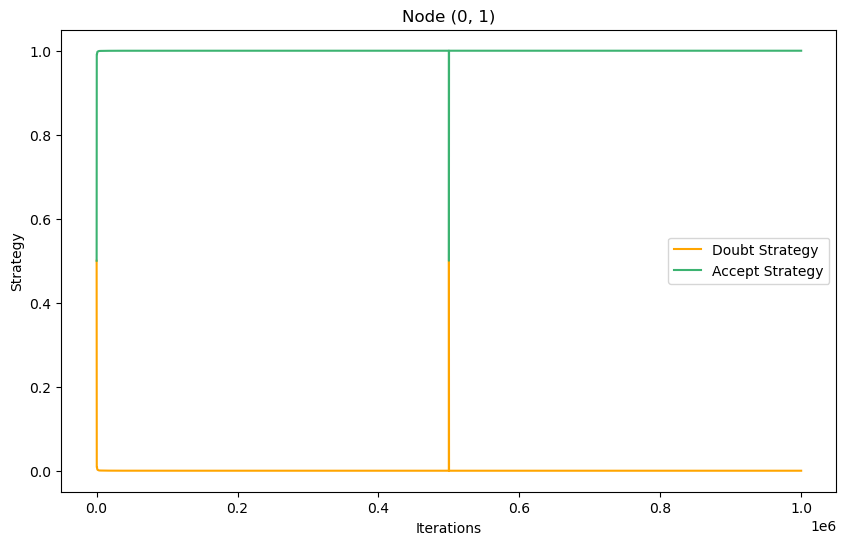

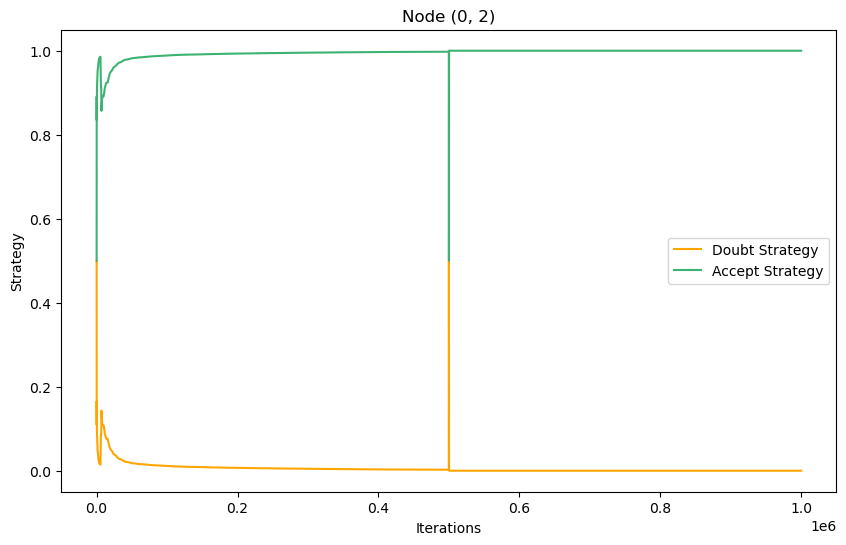

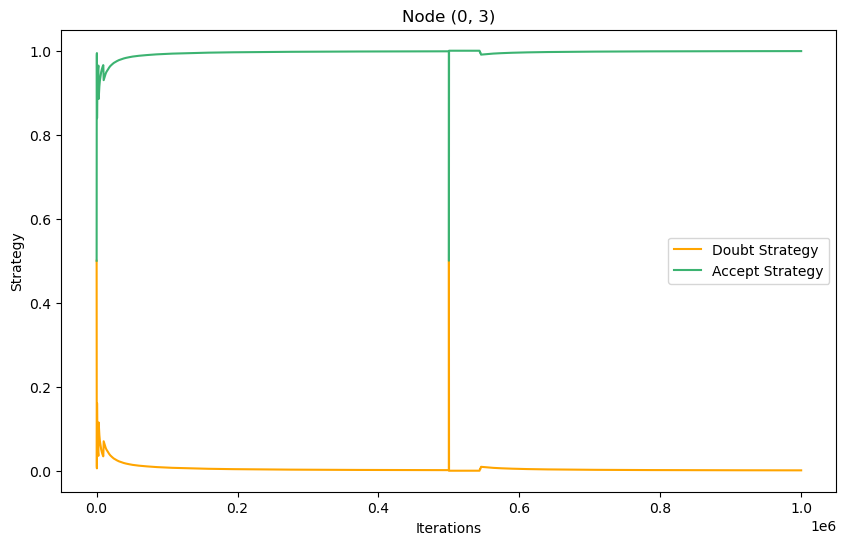

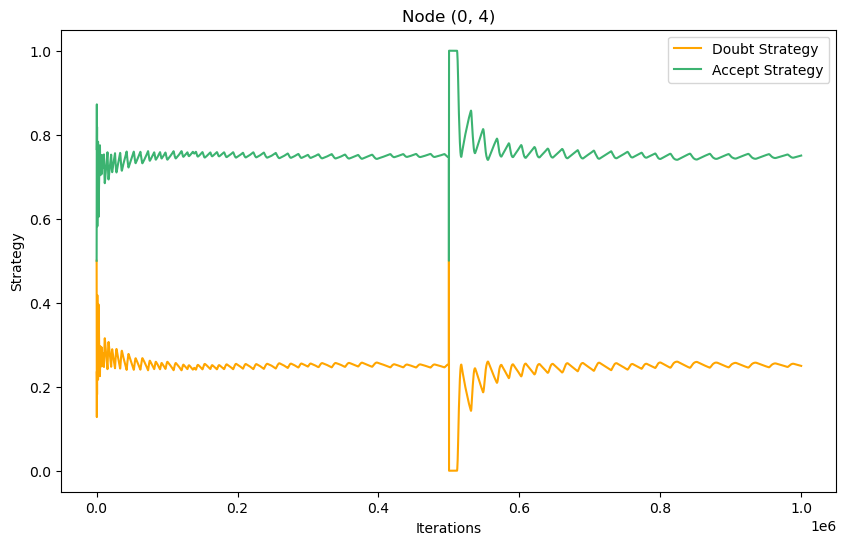

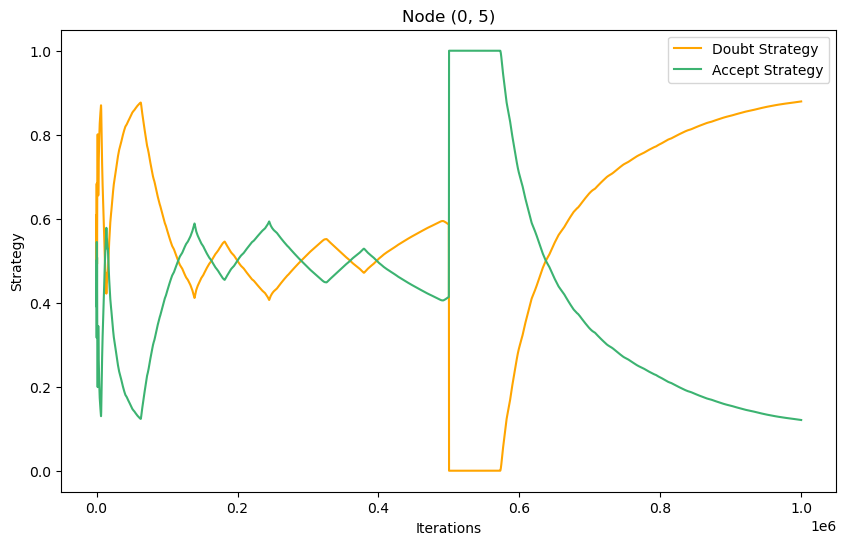

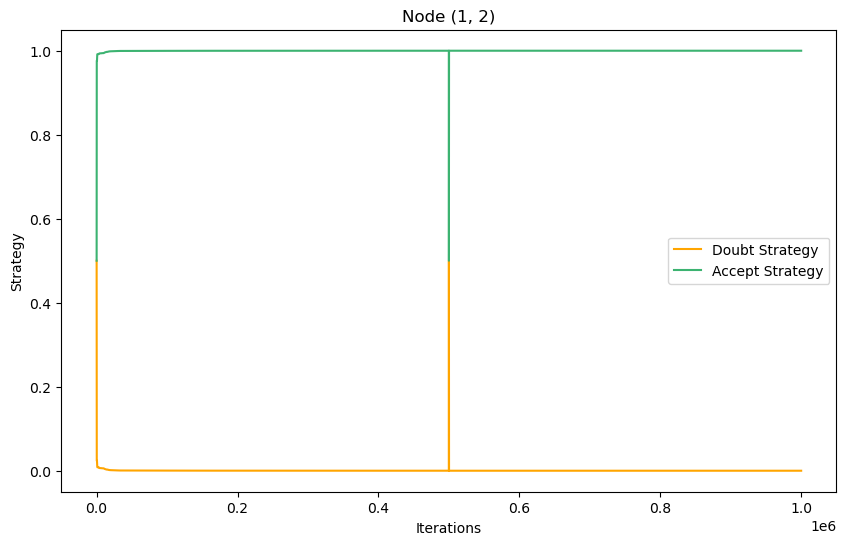

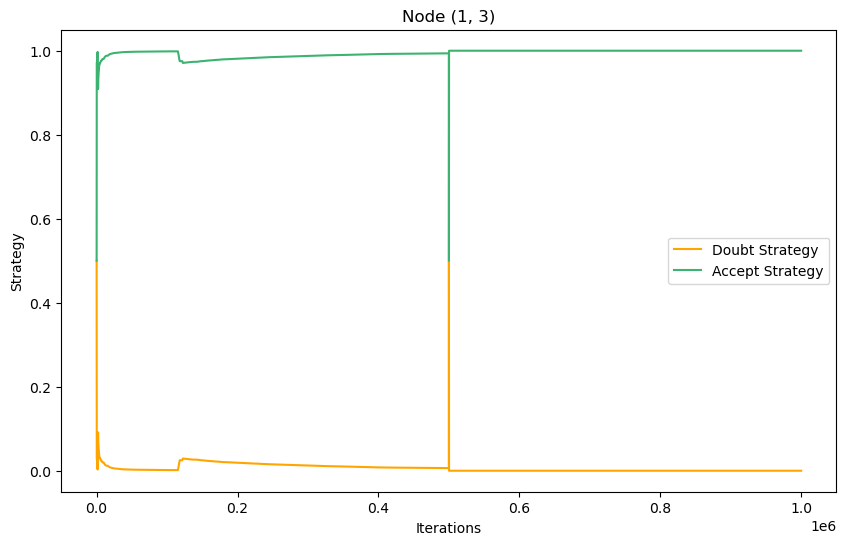

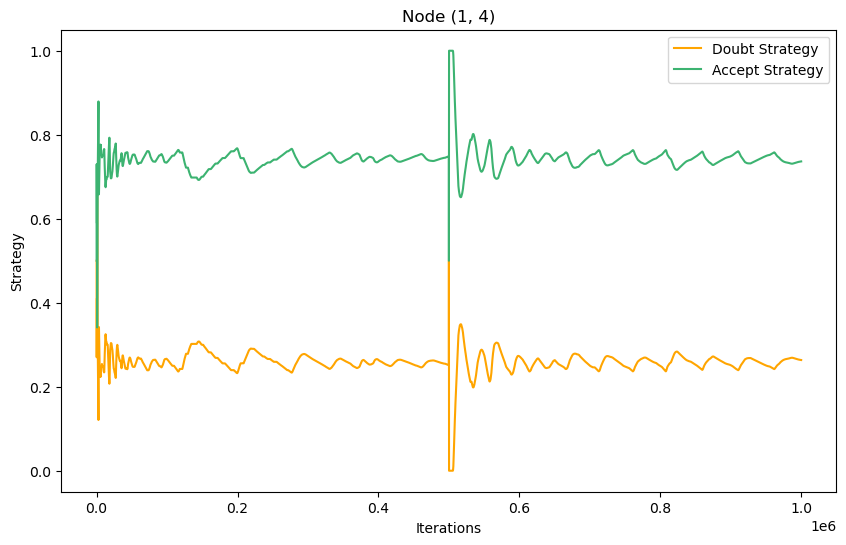

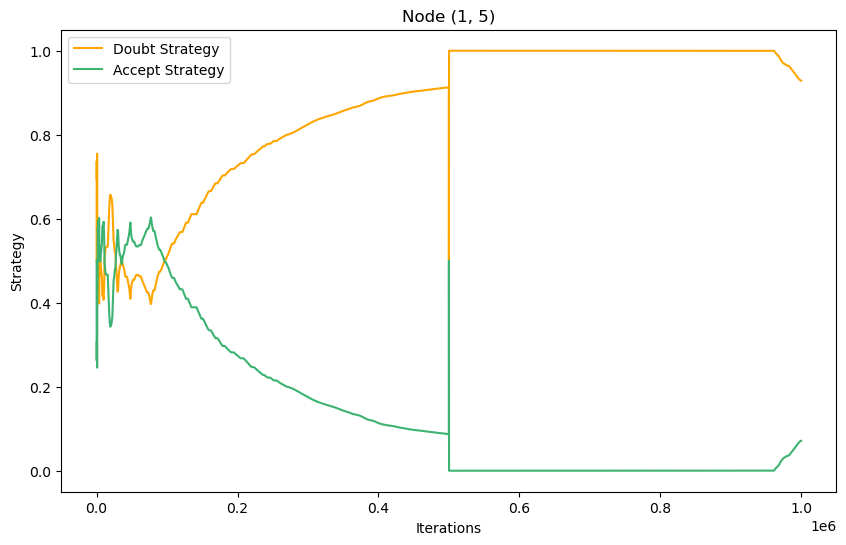

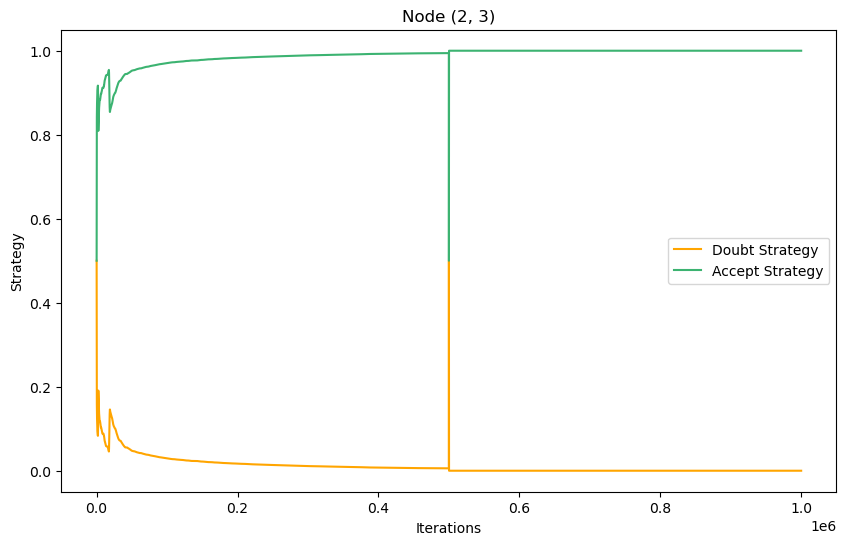

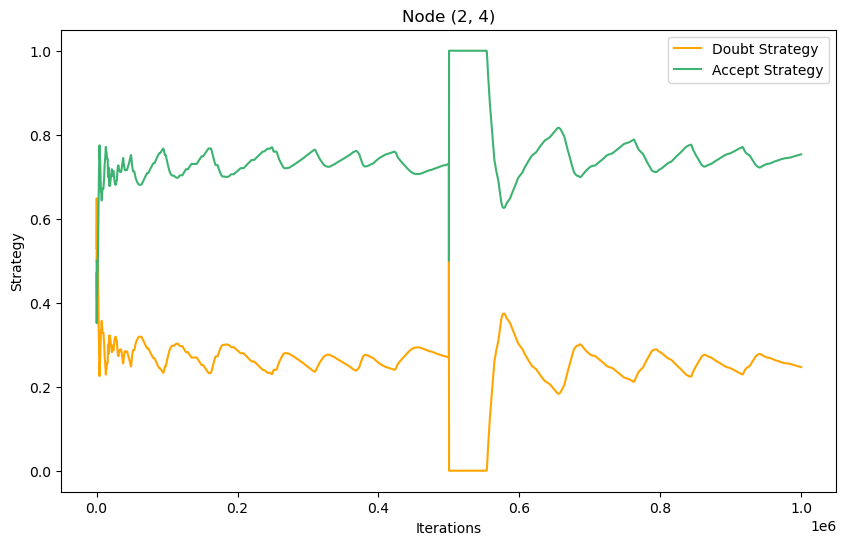

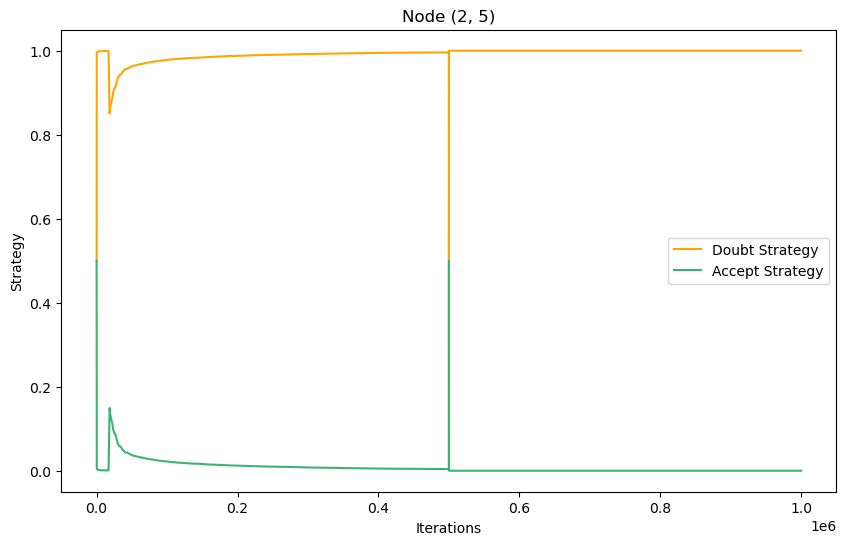

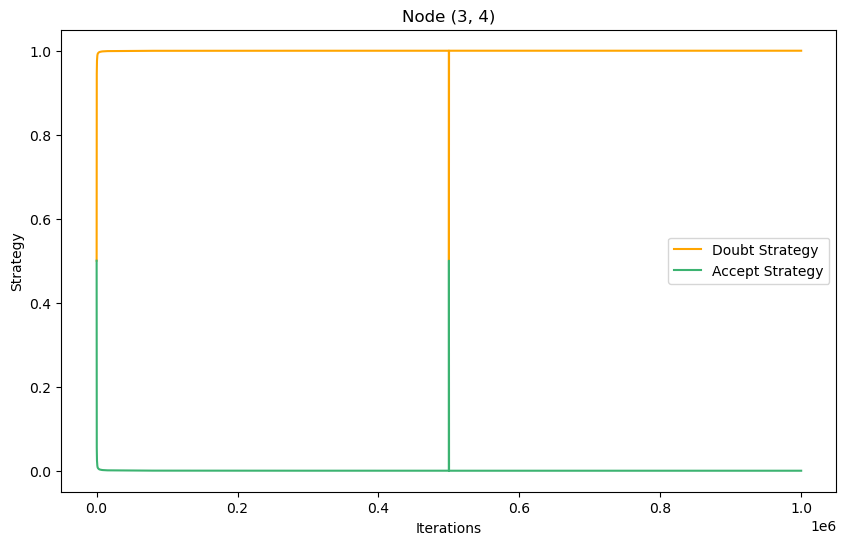

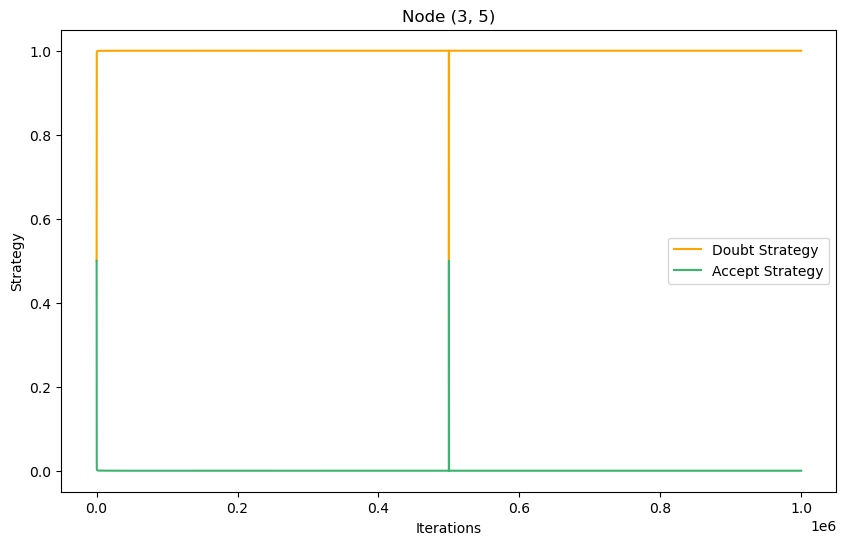

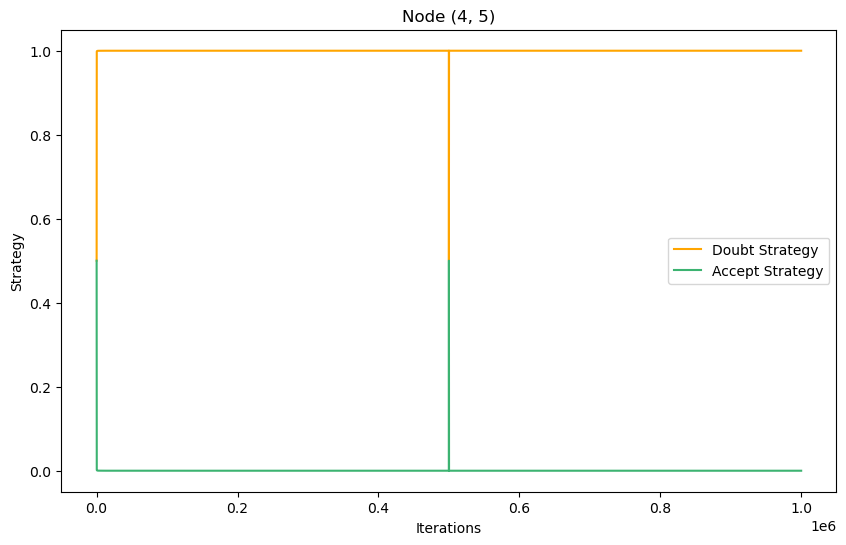

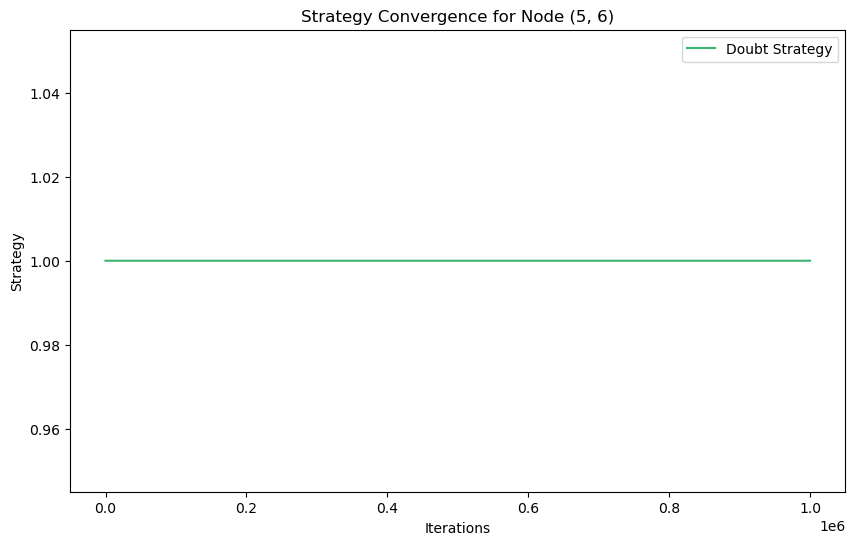

In [60]:
def plotting(strategy_history, sides):
    claims = [z for z in range(7)]
    for j in claims:
        possoible_claim = [y for y in range(j+1, 6)]
        if j == 5:
            strategies_doubt = [record[1][(j, 6)][0] for record in strategy_history]
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, strategies_doubt, label='Doubt Strategy',color='mediumseagreen')
            plt.xlabel('Iterations')
            plt.ylabel('Strategy')
            plt.title(f'Strategy Convergence for Node ({j}, {6})')
            plt.legend()
            
        for i in possoible_claim:
            # Extracting strategy values for plotting
            iterations = [record[0] for record in strategy_history]
            strategies_doubt = [record[1][(j, i)][0] for record in strategy_history]  # DOUBT strategy
            strategies_accept = [record[1][(j, i)][1] for record in strategy_history]  # ACCEPT strategy
            
            plt.figure(figsize=(10, 6))
            plt.plot(iterations, strategies_doubt, label='Doubt Strategy',color='orange')
            plt.plot(iterations, strategies_accept, label='Accept Strategy',color='mediumseagreen')
            plt.xlabel('Iterations')
            plt.ylabel('Strategy')
            plt.title(f'Node ({j}, {i})')
            plt.legend()
            # plt.grid(True)
            plt.show()

plotting(SH, 6)